# Finding Period and Initial Best Fit

In [1]:
#Importing and notebook setup
%matplotlib inline
import os

#For Plotting
import matplotlib.pyplot as plt

#Numbers and Functions
import numpy as np
#Used to open excel file of data
import pandas as pd
#For Maximum Likelihood
from scipy import optimize
#For Periodogram
from gatspy.periodic import LombScargleFast

#Making Tables
from tabulate import tabulate

#for Radvel
import matplotlib
import pylab as pl

import corner

#importing radvel
import radvel
import radvel.plotting

matplotlib.rcParams['font.size'] = 14

Define Periodogram Function

In [2]:
def periodogram(datax, datay, min_, max_, nyquist):
    #finding periodogram
    model = LombScargleFast().fit(datax, datay)
    period, power = model.periodogram_auto(nyquist_factor=nyquist) # Default 50

    #Plotting
    plt.figure
    plt.plot(period,power)
    plt.ylabel('Power')
    plt.xlabel('Period')# days
    plt.xscale('log')
    #used bottom line to zoom in periodogram
#     plt.xlim(min_-1,max_+10)

    # set range and find period
    model.optimizer.period_range=(min_, max_)
    period = model.best_period
    print("period = {0}".format(period))
    return period

Function for RadVel and Residuals

Define a Plotting Function to Display the Data, Model, and Residuals

In [3]:
#used for plotting radvel plots
def plot_results(like):
    fig = pl.figure(figsize=(12,4))
    fig = pl.gcf()
    pl.errorbar(
        like.x, like.model(t)+like.residuals(), 
        yerr=like.yerr, fmt='o'
        )
    pl.plot(ti, like.model(ti))
    fig.set_tight_layout(True)
    pl.xlabel('Time')
    pl.ylabel('RV')
    pl.draw()

Define RMS Function

In [4]:
#getting RMS
def RMS (Residuals):
    RMS = np.std(Residuals)
    return RMS

Using Radvel to Find Model Likelihood

In [5]:
#Found in Radvel.Fitting
def model_likelihood(post,show=False):
    num_planet = post.likelihood.model.num_planets
    ndata = len(post.likelihood.y)
    nfree = len(post.get_vary_params())
    rms = np.std(post.likelihood.residuals())
    logprob = post.logprob()
    chi = np.sum((post.likelihood.residuals()/post.likelihood.errorbars())**2)
    chi_red = chi / (ndata - nfree)
    bic = post.bic()
    if show:
        print "N_free = %d" % nfree
        print "RMS = %4.2f" % np.std(post.likelihood.residuals())
        print "logprob (jitter fixed) = %4.2f" % post.logprob() #radvel.likelihood
        print "chi (jitter fixed) = %4.2f" % chi
        print "chi_red (jitter fixed) = %4.2f" % chi_red
        print "BIC (jitter fixed) = %4.2f" % post.bic()
        
    model_likelihood = [num_planet, ndata, nfree, rms, logprob, chi , chi_red, bic]
    return model_likelihood

My Own Method of Modeling Data

In [6]:
#My own method of plotting and finding likelihood
def residuals(num_planet,data_x, data_y,data_err,amplitude,period,phase_shift,vertical_shift):
    # Target function
    fitfunc = lambda p, x: p[0]*np.cos(2*np.pi/p[1]*x+p[2]) + p[3]*x
    #Distance to the target function
    errfunc = lambda p, x, y: fitfunc(p, x) - y 
    
    # Initial guess for the first set's parameters
    p0 = [amplitude, period, phase_shift, vertical_shift]
    p1, success = optimize.leastsq(errfunc, p0[:], args=(data_x, data_y))
    
    print 'Amplitude: ', np.absolute(p1[0])
    print 'Period: ', p1[1]
    print 'Phase Shift: ', p1[2]
    print 'Vertical-Shift: ',p1[3]
    period = p1[1]
    
    #Finding Residuals
    Residuals = data_y - fitfunc(p1,data_x)
    
    #Finding Likelihood
    ndata = len(data_x)
    nfree = 4.
    RMS = np.std(Residuals)
    logprob = np.log(np.sum(Residuals))
    chi = np.sum(((Residuals)/data_err)**2)
    chi_red = chi / (ndata - nfree)
#     bic = -2.0 * self.logprob() + len(self.likelihood.get_vary_params()) + np.log(len(self.likelihood.y))
    bic = np.log(ndata)+nfree +-2.*logprob
    #chisquared = sum(Residuals**2/(fitfunc(p1,data_x)))
    print "RMS of Residuals: ", RMS
    print "RMS", RMS
    print 'Chi Square', chi
    likelihood = [num_planet, ndata, nfree, RMS, logprob, chi , chi_red, bic]
    
    #Plotting Data with Fit
    time = np.linspace(data_x.min(), data_x.max(), 1000*len(data_x))
    plt.plot(data_x, data_y, "go", time, fitfunc(p1, time),"b-",alpha=0.5)
    plt.title('HD75732')
    plt.xlabel('Time [JD-2.44e6]')
    plt.ylabel('Mean Velocity[m/s]')
    plt.legend(('Data', 'Fit'))
    plt.xlim(data_x[0]-5,data_x[-1]+5)
    ax1 = plt.axes()
    plt.show()
    
    #plotting Residuals
    #plt.plot(data_x, Residuals, "ro", time, fitfunc(p2, time),"b-")
    plt.plot(data_x, Residuals, "ro")
    plt.xlim(data_x[0]-5,data_x[-1]+5)
    plt.ylim(-max(data_y)-10, max(data_y)+10)
    plt.title('Residuals')
    plt.xlabel('Time [JD-2.44e6]')
    plt.ylabel('Mean Velocity[m/s]')
    plt.legend(('Residuals', 'Fit'))
    ax2 = plt.axes()
    
    
    return Residuals, period, likelihood

Importing Data

In [7]:
#Data import
#here data_rj includes both rk data and rj data
data= pd.read_csv('C:/users/rscsa/Research/radvel-master/research/HD75732/HD75732.csv')

#data from different telescopes
#data_rk = data[0:23]
data_rj = data[24:653]

#Naming Variables from data
t = np.array(data_rj.jd)
vel = np.array(data_rj.mnvel)
errvel = np.array(data_rj.errvel)
tel = np.array(data_rj.tel)

#time vector for best fit
ti = np.linspace(t.min(),t.max(),num=len(t)* 10000)
# print data

# Finding Period in Data (1st Planet)

Finding optimal frequency:
 - Estimated peak width = 0.00142
 - Using 5 steps per peak; omega_step = 0.000284
 - User-specified period range:  1 to 4.4e+03
 - Computing periods at 22126 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
period = 14.6521574048


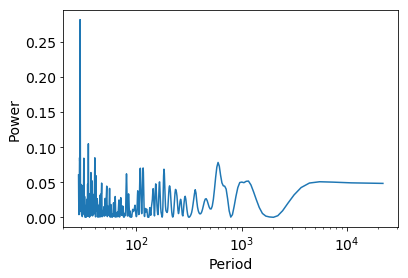

In [8]:
#nyquist - min period for data
nyquist = .5
#finding first planet period
period1 = periodogram(t,vel,1,max(t)-min(t),nyquist)

Initializing Radvel

In [9]:
nplanets = 1
instnames = ['k', 'j']    # list of instrument names. Can be whatever you like but should match 'tel' column in the input file.
ntels = len(instnames)       # number of instruments with unique velocity zero-points

def initialize_model():
    time_base = 2420
    params = radvel.RVParameters(nplanets,basis='per tc secosw sesinw logk')
    
    #1st Planet
    params['per1'] = period1    # period of 1st planet
    params['tc1'] = 2074.52   # time of inferior conjunction of 1st planet
    params['secosw1'] = 0.01 
    params['sesinw1'] =  0.01 
    params['logk1'] =  np.log(50)   # velocity semi-amplitude for 1st planet  
    

    mod = radvel.RVModel(params, time_base=time_base)
    mod.params['dvdt'] = 0.0         # slope
    mod.params['curv'] = 0.0        # curvature  
    return mod

In [10]:
mod = initialize_model()
like = radvel.likelihood.RVLikelihood(mod, t, vel, errvel)
like.params['gamma'] = 1.0
like.params['jit'] = 2.6

# like.params['gamma_k'] = 0.0
# like.params['gamma_j'] = 1.0
# like.params['jit_k'] = 2.6
# like.params['jit_j'] = 2.6

Defining Variables that are Going to Vary.

In [11]:
like.vary['curv'] = True
like.vary['dvdt'] = True
#like.vary['per1'] = False
#like.vary['logk1'] = False
#like.vary['secosw1'] = False
#like.vary['sesinw1'] = False
#like.vary['tc1'] = False

Plotting Radvels Initial Likelihood

C:\Users\rscsa\Anaconda2\lib\site-packages\matplotlib\figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


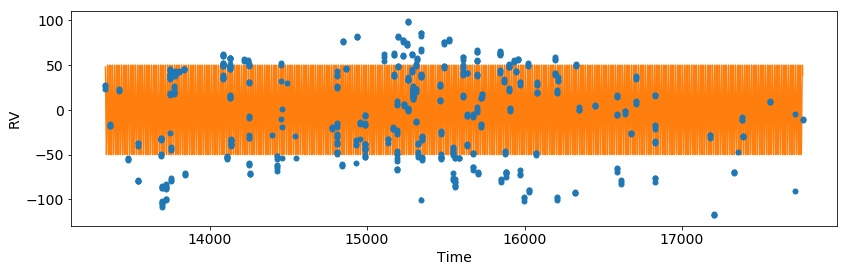

In [12]:
pl.figure()
plot_results(like)
# radvel.plotting.rv_multipanel_plot(post, epoch=2440000)

Maximize the Likelihood and Print the Updated Posterior Object

In [13]:
post = radvel.posterior.Posterior(like)

post.priors += [radvel.prior.Gaussian('per1',like.params['per1'],.25*like.params['per1'])]

post.priors += [radvel.prior.EccentricityPrior(nplanets)] #change for # of planets
post.priors += [radvel.prior.PositiveKPrior( nplanets )]

post.priors += [radvel.prior.Gaussian( 'jit', np.log(1), np.log(15))]
#post.priors += [radvel.prior.Gaussian( 'jit_k', np.log(1), np.log(15))]
#post.priors += [radvel.prior.Gaussian( 'jit_j', np.log(1), np.log(15))]

print post

parameter                     value      vary
per1                        14.6522       True
tc1                         2074.52       True
secosw1                        0.01       True
sesinw1                        0.01       True
logk1                       3.91202       True
dvdt                              0       True
curv                              0       True
jit                             2.6       True
gamma                             1       True

Priors
------
Gaussian prior on per1, mu=14.6521574048, sigma=3.66303935119
e1 constrained to be < 0.99
K constrained to be > 0
Gaussian prior on jit, mu=0.0, sigma=2.7080502011



parameter                     value      vary
per1                        14.6518       True
tc1                         2074.48       True
secosw1                   0.0798337       True
sesinw1                  -0.0809386       True
logk1                       4.17498       True
dvdt                   -0.000776938       True
curv                   -7.16438e-09       True
jit                         21.3251       True
gamma                       2.72031       True

Priors
------
Gaussian prior on per1, mu=14.6521574048, sigma=3.66303935119
e1 constrained to be < 0.99
K constrained to be > 0
Gaussian prior on jit, mu=0.0, sigma=2.7080502011



C:\Users\rscsa\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


(<matplotlib.figure.Figure at 0xf1f3978>,
  <matplotlib.axes._subplots.AxesSubplot at 0xf999f60>])

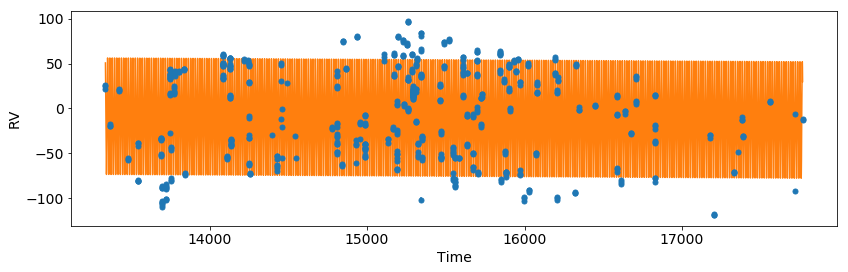

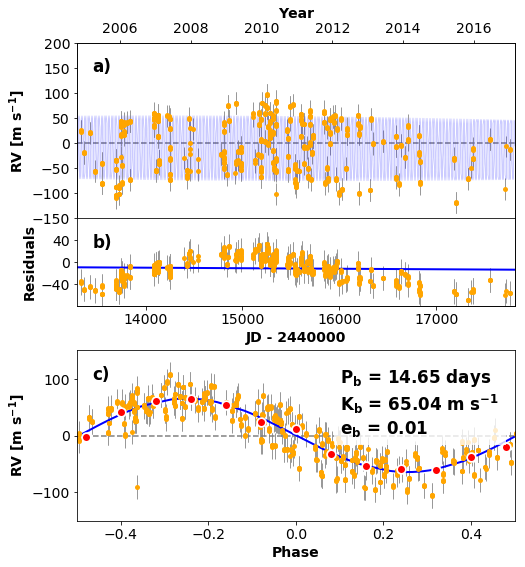

In [14]:
res  = optimize.minimize(
    post.neglogprob_array,     # objective function is negative log likelihood
    post.get_vary_params(),    # initial variable parameters
    method='Powell',           # Nelder-Mead also works
    )
#Get residuals
#orbel = []
#radvel.kepler.rv_drive(t)
plot_results(like)             # plot best fit model
print post
radvel.plotting.rv_multipanel_plot(post,epoch=2440000)

In [15]:
# res  = optimize.minimize(
#     post.neglogprob_array,     # objective function is negative log likelihood
#     post.get_vary_params(),    # initial variable parameters
#     method='Powell',           # Nelder-Mead also works
#     )
# #Get residuals
# #orbel = []
# #radvel.kepler.rv_drive(t)
# plot_results(like)             # plot best fit model
# print post
# radvel.plotting.rv_multipanel_plot(post, telfmts=radvel.plotting.telfmts_default,epoch=2440000)

Finding the Model Likelihood, using RMS, Chi Squared, Log Probability, & BIC

In [16]:
Residuals_Radvel_1 = post.likelihood.residuals()
RMS_Radvel_1 = RMS(Residuals_Radvel_1)
print 'Radvel RMS of Residuals: ', RMS_Radvel_1
print ' '
print ' '

one_planet= model_likelihood(post, True)

Radvel RMS of Residuals:  22.360981816
 
 
N_free = 9
RMS = 22.36
logprob (jitter fixed) = -2879.07
chi (jitter fixed) = 689.43
chi_red (jitter fixed) = 1.11
BIC (jitter fixed) = 5773.59


# ***********Attempting to use Multiple Data***********

In [17]:
# http://radvel.readthedocs.io/en/master/_modules/radvel/plotting.html?highlight=tel
# Using Radvel.fitting
# not sure what "ax" is on arguments
# not sure how to use "telfmts_default[ ]" 
# ax = 0
# radvel.plotting._mtelplot(t,vel,ax,errvel, telfmts={'hires_rj','hires_rk'})

# Initial Best Fit My Own Way (1st Planet)

Finding Model for Data

Amplitude:  64.801436309
Period:  14.6530055197
Phase Shift:  -1.59442142435
Vertical-Shift:  -0.000536193798557
RMS of Residuals:  22.3551287245
RMS 22.3551287245
Chi Square 324902.149296


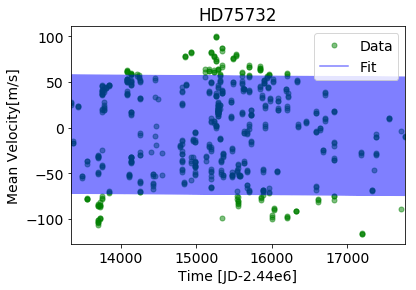

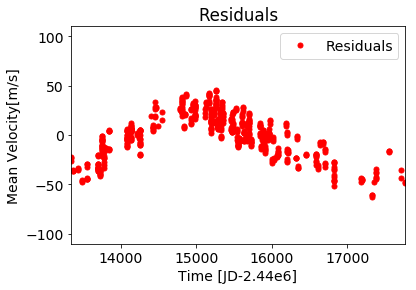

In [18]:
guess_amp = 50.
guess_pshft =0.
guess_vshft = 0.
residuals1, period1, likelihood1 = residuals(nplanets,t,vel,errvel,guess_amp,period1,guess_pshft,guess_vshft)

# Finding Period for 2nd Planet

Looking at Residuals for another Period

Finding optimal frequency:
 - Estimated peak width = 0.00142
 - Using 5 steps per peak; omega_step = 0.000284
 - User-specified period range:  1 to 4.4e+03
 - Computing periods at 22126 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
period = 3782.78629915


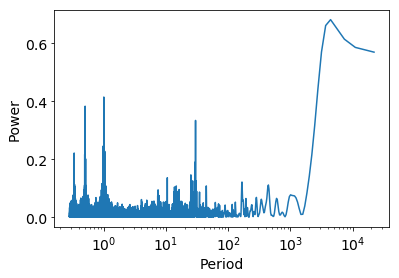

In [19]:
period_radvel_2 = periodogram(t,Residuals_Radvel_1,1,max(t)-min(t),50)

In [20]:
nplanets = 2
# instnames = ['k', 'j']    # list of instrument names. Can be whatever you like but should match 'tel' column in the input file.
# ntels = len(instnames)       # number of instruments with unique velocity zero-points

def initialize_model():
    time_base = 2420
    params = radvel.RVParameters(nplanets,basis='per tc secosw sesinw logk')
    
    #1st Planet
    params['per1'] = post.params['per1']    # period of 1st planet
    params['tc1'] = post.params['tc1']   # time of inferior conjunction of 1st planet
    params['secosw1'] = post.params['secosw1']
    params['sesinw1'] =  post.params['sesinw1']
    params['logk1'] =  post.params['logk1']   # velocity semi-amplitude for 1st planet
    
    #2nd planet    
    params['per2'] = period_radvel_2 
    params['tc2'] =  4268.95 + 1000   
    params['secosw2'] = 0.01  
    params['sesinw2'] = 0.01 
    params['logk2'] = np.log(RMS_Radvel_1)   
    

    mod = radvel.RVModel(params, time_base=time_base)
    mod.params['dvdt'] = 0.0         # slope
    mod.params['curv'] = 0.0        # curvature  
    return mod

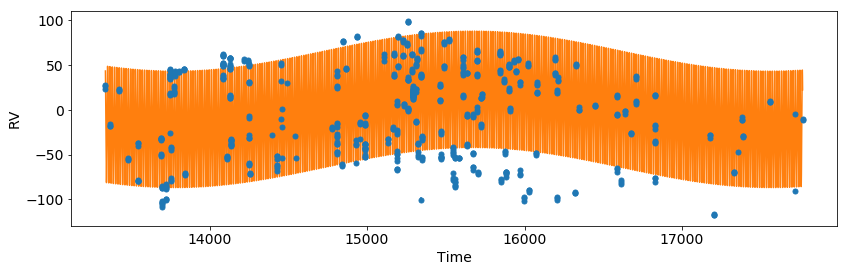

In [21]:
mod = initialize_model()
like = radvel.likelihood.RVLikelihood(mod, t, vel, errvel)
like.params['gamma'] = 1.0
like.params['jit'] = 2.6

like.vary['curv'] = True
like.vary['dvdt'] = True

pl.figure()
plot_results(like)

In [22]:
post = radvel.posterior.Posterior(like)

post.priors += [radvel.prior.Gaussian('per1',like.params['per1'],.25*like.params['per1'])]
post.priors += [radvel.prior.Gaussian('per2',like.params['per2'],.25*like.params['per2'])]
post.priors += [radvel.prior.EccentricityPrior(nplanets)] #change for # of planets
post.priors += [radvel.prior.PositiveKPrior( nplanets )]

post.priors += [radvel.prior.Gaussian( 'jit', np.log(1), np.log(15))]

print post

parameter                     value      vary
per1                        14.6518       True
tc1                         2074.48       True
secosw1                   0.0798337       True
sesinw1                  -0.0809386       True
logk1                       4.17498       True
per2                        3782.79       True
tc2                         5268.95       True
secosw2                        0.01       True
sesinw2                        0.01       True
logk2                       3.10732       True
dvdt                              0       True
curv                              0       True
jit                             2.6       True
gamma                             1       True

Priors
------
Gaussian prior on per1, mu=14.6518449725, sigma=3.66296124313
Gaussian prior on per2, mu=3782.78629915, sigma=945.696574786
e1 constrained to be < 0.99
e2 constrained to be < 0.99
K constrained to be > 0
Gaussian prior on jit, mu=0.0, sigma=2.7080502011



C:\Users\rscsa\Anaconda2\lib\site-packages\scipy\optimize\optimize.py:1876: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
C:\Users\rscsa\Anaconda2\lib\site-packages\scipy\optimize\optimize.py:1881: RuntimeWarning: invalid value encountered in absolute
  tmp2 = numpy.abs(tmp2)


parameter                     value      vary
per1                        14.6507       True
tc1                         2075.33       True
secosw1                    0.182707       True
sesinw1                    0.127073       True
logk1                       4.23345       True
per2                        2855.42       True
tc2                         4569.65       True
secosw2                   -0.425635       True
sesinw2                    0.164741       True
logk2                       3.22722       True
dvdt                    -0.00329398       True
curv                    -1.9268e-07       True
jit                         14.3855       True
gamma                       63.5789       True

Priors
------
Gaussian prior on per1, mu=14.6518449725, sigma=3.66296124313
Gaussian prior on per2, mu=3782.78629915, sigma=945.696574786
e1 constrained to be < 0.99
e2 constrained to be < 0.99
K constrained to be > 0
Gaussian prior on jit, mu=0.0, sigma=2.7080502011



(<matplotlib.figure.Figure at 0xdfb7a90>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1d0ad400>])

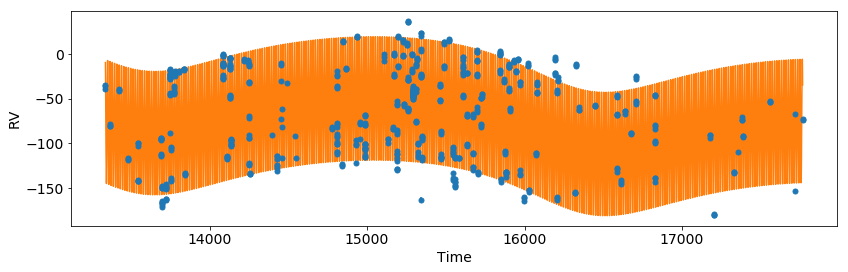

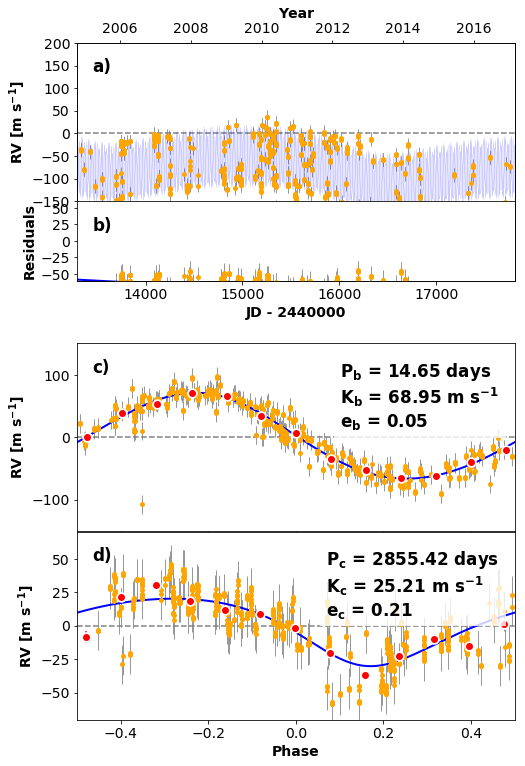

In [23]:
res  = optimize.minimize(
    post.neglogprob_array,     # objective function is negative log likelihood
    post.get_vary_params(),    # initial variable parameters
    method='Powell',           # Nelder-Mead also works
    )

plot_results(like)             # plot best fit model
print post
radvel.plotting.rv_multipanel_plot(post, epoch=2440000)

In [24]:
# res  = optimize.minimize(
#     post.neglogprob_array,     # objective function is negative log likelihood
#     post.get_vary_params(),    # initial variable parameters
#     method='Powell',           # Nelder-Mead also works
#     )
# #Get residuals
# #orbel = []
# #radvel.kepler.rv_drive(t)
# plot_results(like)             # plot best fit model
# print post
# radvel.plotting.rv_multipanel_plot(post, telfmts=radvel.plotting.telfmts_default,epoch=2440000)

In [25]:
Residuals_Radvel_2 = post.likelihood.residuals()
RMS_Radvel_2 = RMS(Residuals_Radvel_2)
print 'Radvel RMS of Residuals: ', RMS_Radvel_2
print ' '
print ' '

#Model Likelihood
two_planet= model_likelihood(post, True)

Radvel RMS of Residuals:  14.8438334637
 
 
N_free = 14
RMS = 14.84
logprob (jitter fixed) = -2602.28
chi (jitter fixed) = 662.30
chi_red (jitter fixed) = 1.08
BIC (jitter fixed) = 5225.01


# Initial Best Fit My Own Way (2nd Planet)

Period for my own method

Finding optimal frequency:
 - Estimated peak width = 0.00142
 - Using 5 steps per peak; omega_step = 0.000284
 - User-specified period range:  1 to 4.4e+03
 - Computing periods at 22126 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
period = 3909.77029152


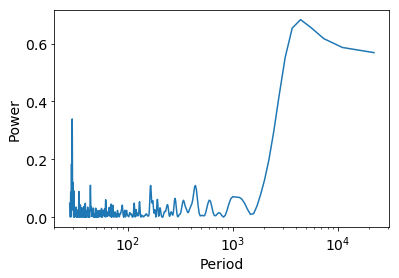

In [26]:
period2 = periodogram(t,residuals1,1,max(t)-min(t),nyquist)

Amplitude:  30.6992890461
Period:  4264.07023268
Phase Shift:  3.00918256009
Vertical-Shift:  -0.000657741056046
RMS of Residuals:  12.6265207954
RMS 12.6265207954
Chi Square 82813.3716966


C:\Users\rscsa\Anaconda2\lib\site-packages\ipykernel\__main__.py:25: RuntimeWarning: invalid value encountered in log


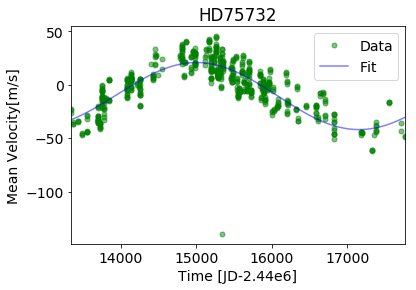

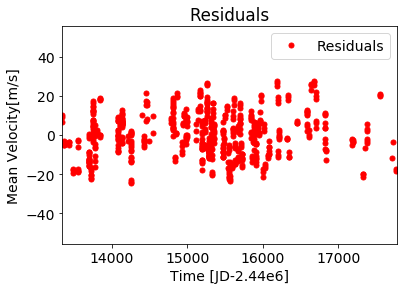

In [27]:
guess_amp = 30.
guess_pshft = 0.
guess_vshft = 0.
residuals2, period2, likelihood2 = residuals(nplanets, t, residuals1, errvel, guess_amp, period2, guess_pshft, guess_vshft)

# Finding Period for Planet 3

Finding optimal frequency:
 - Estimated peak width = 0.00142
 - Using 5 steps per peak; omega_step = 0.000284
 - User-specified period range:  1 to 4.4e+03
 - Computing periods at 22126 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
period = 44.4069188088


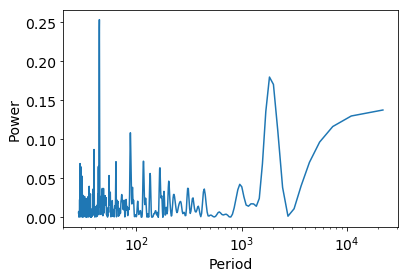

In [28]:
period_radvel_3 = periodogram(t,Residuals_Radvel_2,1,max(t)-min(t),nyquist)

In [29]:
nplanets = 3
# instnames = ['k', 'j']    # list of instrument names. Can be whatever you like but should match 'tel' column in the input file.
# ntels = len(instnames)       # number of instruments with unique velocity zero-points

def initialize_model():
    time_base = 2420
    params = radvel.RVParameters(nplanets,basis='per tc secosw sesinw logk')
    
    #1st Planet
    params['per1'] = post.params['per1']    # period of 1st planet
    params['tc1'] = post.params['tc1']   # time of inferior conjunction of 1st planet
    params['secosw1'] = post.params['secosw1']
    params['sesinw1'] =  post.params['sesinw1']
    params['logk1'] =  post.params['logk1']   # velocity semi-amplitude for 1st planet
    
    #2nd planet    
    params['per2'] = post.params['per2']
    params['tc2'] =  post.params['tc2']  
    params['secosw2'] = post.params['secosw2']
    params['sesinw2'] = post.params['sesinw2']
    params['logk2'] = post.params['logk2'] 

    #3rd Planet
    params['per3'] = period_radvel_3
    params['tc3'] = 2087.07 
    params['secosw3'] = 0.01
    params['sesinw3'] =  0.01 
    params['logk3'] = np.log(RMS_Radvel_2)
    
    

    mod = radvel.RVModel(params, time_base=time_base)
    mod.params['dvdt'] = 0.0         # slope
    mod.params['curv'] = 0.0        # curvature  
    return mod

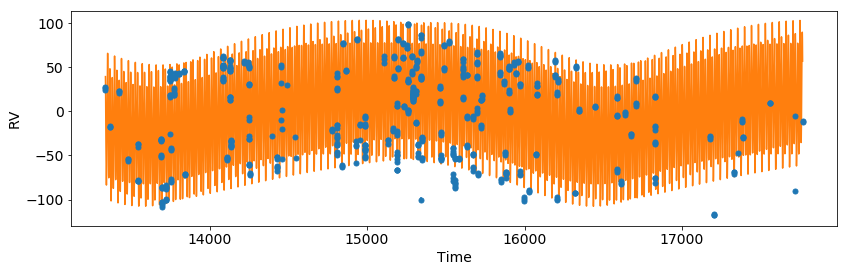

In [30]:
mod = initialize_model()
like = radvel.likelihood.RVLikelihood(mod, t, vel, errvel)
like.params['gamma'] = 1.0
like.params['jit'] = 2.6

like.vary['curv'] = True
like.vary['dvdt'] = True

pl.figure()
plot_results(like)

In [31]:
post = radvel.posterior.Posterior(like)

post.priors += [radvel.prior.Gaussian('per1',like.params['per1'],.25*like.params['per1'])]
post.priors += [radvel.prior.Gaussian('per2',like.params['per2'],.25*like.params['per2'])]
post.priors += [radvel.prior.Gaussian('per3',like.params['per3'],.25*like.params['per3'])]

post.priors += [radvel.prior.EccentricityPrior(nplanets)] #change for # of planets
post.priors += [radvel.prior.PositiveKPrior( nplanets )]

post.priors += [radvel.prior.Gaussian( 'jit', np.log(1), np.log(15))]

print post

parameter                     value      vary
per1                        14.6507       True
tc1                         2075.33       True
secosw1                    0.182707       True
sesinw1                    0.127073       True
logk1                       4.23345       True
per2                        2855.42       True
tc2                         4569.65       True
secosw2                   -0.425635       True
sesinw2                    0.164741       True
logk2                       3.22722       True
per3                        44.4069       True
tc3                         2087.07       True
secosw3                        0.01       True
sesinw3                        0.01       True
logk3                       2.69758       True
dvdt                              0       True
curv                              0       True
jit                             2.6       True
gamma                             1       True

Priors
------
Gaussian prior on per1, mu=14.6507219212, sigm

parameter                     value      vary
per1                        14.6534       True
tc1                         2073.05       True
secosw1                   0.0123893       True
sesinw1                     0.13959       True
logk1                       4.25679       True
per2                        3546.25       True
tc2                         1905.52       True
secosw2                   -0.135813       True
sesinw2                   -0.459131       True
logk2                       3.35122       True
per3                        44.3365       True
tc3                         2098.74       True
secosw3                    0.533826       True
sesinw3                    0.259509       True
logk3                       2.41136       True
dvdt                    -0.00427168       True
curv                   -1.28966e-07       True
jit                         9.59379       True
gamma                       64.3837       True

Priors
------
Gaussian prior on per1, mu=14.6507219212, sigm

(<matplotlib.figure.Figure at 0x2c472e10>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1ddf4f98>])

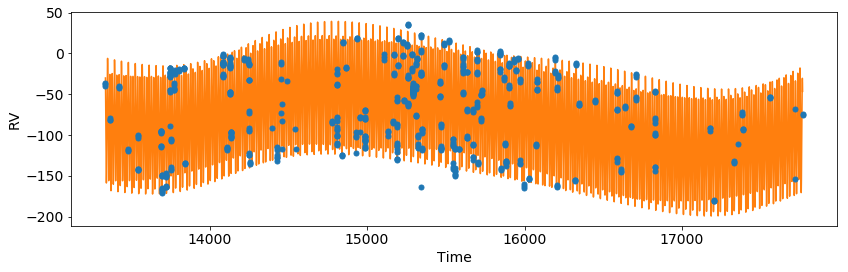

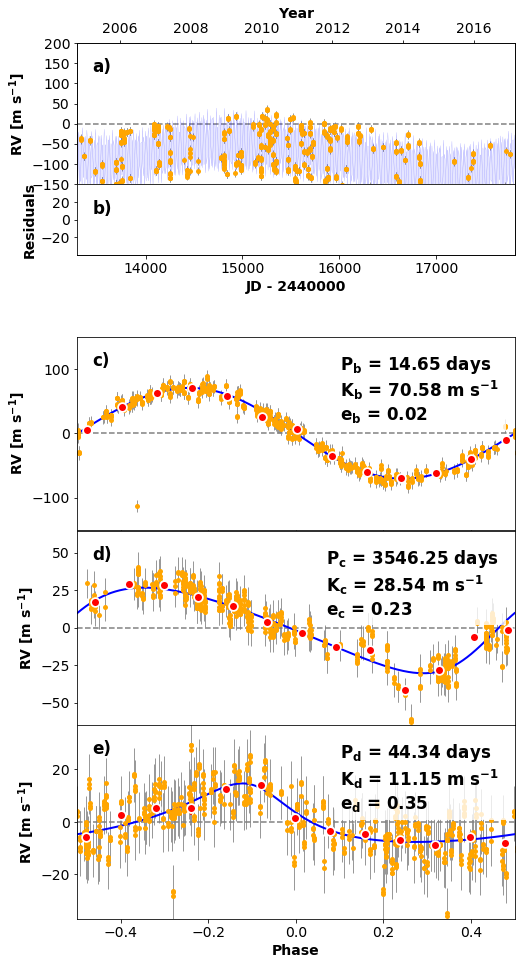

In [32]:
res  = optimize.minimize(
    post.neglogprob_array,     # objective function is negative log likelihood
    post.get_vary_params(),    # initial variable parameters
    method='Powell',           # Nelder-Mead also works
    )

plot_results(like)             # plot best fit model
print post
radvel.plotting.rv_multipanel_plot(post, epoch=2440000)

In [33]:
# res  = optimize.minimize(
#     post.neglogprob_array,     # objective function is negative log likelihood
#     post.get_vary_params(),    # initial variable parameters
#     method='Powell',           # Nelder-Mead also works
#     )
# #Get residuals
# #orbel = []
# #radvel.kepler.rv_drive(t)
# plot_results(like)             # plot best fit model
# print post
# radvel.plotting.rv_multipanel_plot(post, telfmts=radvel.plotting.telfmts_default,epoch=2440000)

In [34]:
Residuals_Radvel_3 = post.likelihood.residuals()
RMS_Radvel_3 = RMS(Residuals_Radvel_3)
print 'Radvel RMS of Residuals: ', RMS_Radvel_3
print ' '
print ' '

#model likelihood
three_planet= model_likelihood(post, True)

Radvel RMS of Residuals:  10.0077838752
 
 
N_free = 19
RMS = 10.01
logprob (jitter fixed) = -2337.97
chi (jitter fixed) = 655.32
chi_red (jitter fixed) = 1.07
BIC (jitter fixed) = 4701.38


# Initial Best Fit My Own Way (3rd Planet)

Finding optimal frequency:
 - Estimated peak width = 0.00142
 - Using 5 steps per peak; omega_step = 0.000284
 - User-specified period range:  1 to 4.4e+03
 - Computing periods at 22126 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
period = 44.3882132828


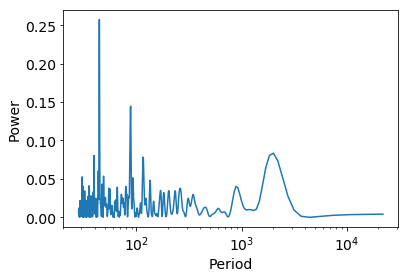

In [35]:
period3 = periodogram(t,residuals2,1,max(t)-min(t),nyquist)

Amplitude:  8.9857357728
Period:  44.396084916
Phase Shift:  1.84784457954
Vertical-Shift:  2.02699264661e-05
RMS of Residuals:  10.8820245297
RMS 10.8820245297
Chi Square 54449.1584017


C:\Users\rscsa\Anaconda2\lib\site-packages\ipykernel\__main__.py:25: RuntimeWarning: invalid value encountered in log


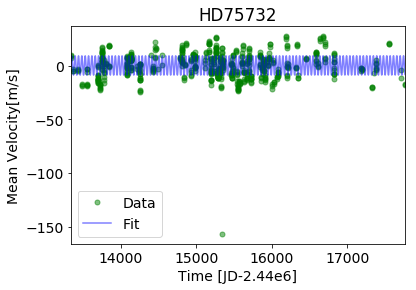

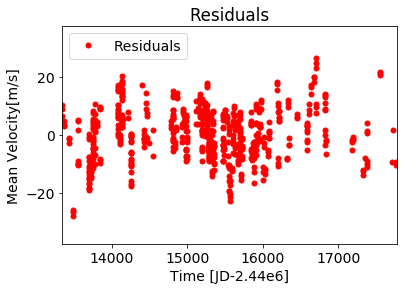

In [36]:
guess_amp = 20.
guess_pshft =0.
guess_vshft = 0.
residuals3, period3, likelihood3 = residuals(nplanets, t, residuals2, errvel, guess_amp, period3, guess_pshft, guess_vshft)

# Finding 4th Planet

Finding optimal frequency:
 - Estimated peak width = 0.00142
 - Using 5 steps per peak; omega_step = 0.000284
 - User-specified period range:  1 to 4.4e+03
 - Computing periods at 22126 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
period = 2.81772688321


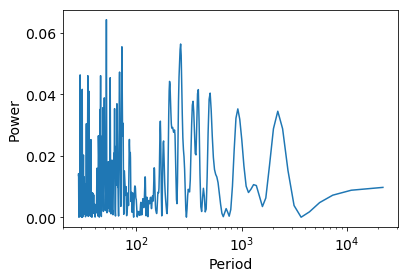

In [37]:
period_radvel_4 = periodogram(t,Residuals_Radvel_3,1,max(t)-min(t),nyquist)
#Corrected Alias Period
period_radvel_4 = 0.7365418

In [38]:
nplanets = 4
# instnames = ['k', 'j']    # list of instrument names. Can be whatever you like but should match 'tel' column in the input file.
# ntels = len(instnames)       # number of instruments with unique velocity zero-points

def initialize_model():
    time_base = 2420
    params = radvel.RVParameters(nplanets,basis='per tc secosw sesinw logk')
    
    #1st Planet
    params['per1'] = post.params['per1']    # period of 1st planet
    params['tc1'] = post.params['tc1']   # time of inferior conjunction of 1st planet
    params['secosw1'] = post.params['secosw1']
    params['sesinw1'] =  post.params['sesinw1']
    params['logk1'] =  post.params['logk1']   # velocity semi-amplitude for 1st planet
    
    #2nd planet    
    params['per2'] = post.params['per2']
    params['tc2'] =  post.params['tc2']  
    params['secosw2'] = post.params['secosw2']
    params['sesinw2'] = post.params['sesinw2']
    params['logk2'] = post.params['logk2']  

    #3rd Planet
    params['per3'] = post.params['per3']
    params['tc3'] = post.params['tc3']
    params['secosw3'] = post.params['secosw3']
    params['sesinw3'] =  post.params['sesinw3']
    params['logk3'] = post.params['logk3']
    
    #4th Planet
    params['per4'] = period_radvel_4
    params['tc4'] = 2087.07 -1000   
    params['secosw4'] = 0.01
    params['sesinw4'] = 0.01
    params['logk4'] = np.log(RMS_Radvel_3)   
 
    

    mod = radvel.RVModel(params, time_base=time_base)
    mod.params['dvdt'] = 0.0         # slope
    mod.params['curv'] = 0.0        # curvature  
    return mod

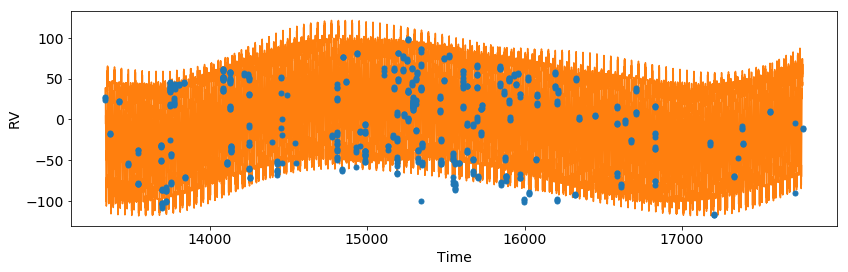

In [39]:
mod = initialize_model()
like = radvel.likelihood.RVLikelihood(mod, t, vel, errvel)
like.params['gamma'] = 1.0
like.params['jit'] = 2.6

like.vary['curv'] = True
like.vary['dvdt'] = True

pl.figure()
plot_results(like)

In [40]:
post = radvel.posterior.Posterior(like)

post.priors += [radvel.prior.Gaussian('per1',like.params['per1'],.25*like.params['per1'])]
post.priors += [radvel.prior.Gaussian('per2',like.params['per2'],.25*like.params['per2'])]
post.priors += [radvel.prior.Gaussian('per3',like.params['per3'],.25*like.params['per3'])]
post.priors += [radvel.prior.Gaussian('per4',like.params['per4'],.25*like.params['per4'])]
# post.priors += [radvel.prior.Gaussian('per4',like.params['per4'],0.0000026)]

post.priors += [radvel.prior.EccentricityPrior(nplanets)] #change for # of planets
post.priors += [radvel.prior.PositiveKPrior( nplanets )]

post.priors += [radvel.prior.Gaussian( 'jit', np.log(1), np.log(15))]

print post

parameter                     value      vary
per1                        14.6534       True
tc1                         2073.05       True
secosw1                   0.0123893       True
sesinw1                     0.13959       True
logk1                       4.25679       True
per2                        3546.25       True
tc2                         1905.52       True
secosw2                   -0.135813       True
sesinw2                   -0.459131       True
logk2                       3.35122       True
per3                        44.3365       True
tc3                         2098.74       True
secosw3                    0.533826       True
sesinw3                    0.259509       True
logk3                       2.41136       True
per4                       0.736542       True
tc4                         1087.07       True
secosw4                        0.01       True
sesinw4                        0.01       True
logk4                       2.30336       True
dvdt          

parameter                     value      vary
per1                        14.6523       True
tc1                         2074.15       True
secosw1                  -0.0466767       True
sesinw1                    0.079454       True
logk1                       4.25318       True
per2                        3802.23       True
tc2                         915.546       True
secosw2                  -0.0878501       True
sesinw2                   -0.486143       True
logk2                       3.42275       True
per3                        44.4194       True
tc3                         2119.13       True
secosw3                     0.35566       True
sesinw3                    0.450029       True
logk3                       2.35148       True
per4                       0.736535       True
tc4                         1087.01       True
secosw4                    0.229959       True
sesinw4                    0.135491       True
logk4                       1.87597       True
dvdt          

(<matplotlib.figure.Figure at 0x19fea630>,
  <matplotlib.axes._subplots.AxesSubplot at 0x2bfd39b0>])

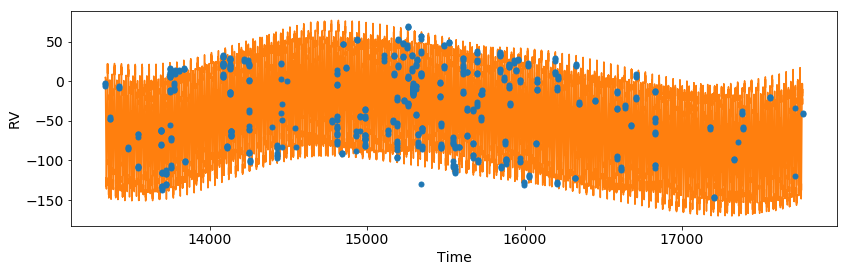

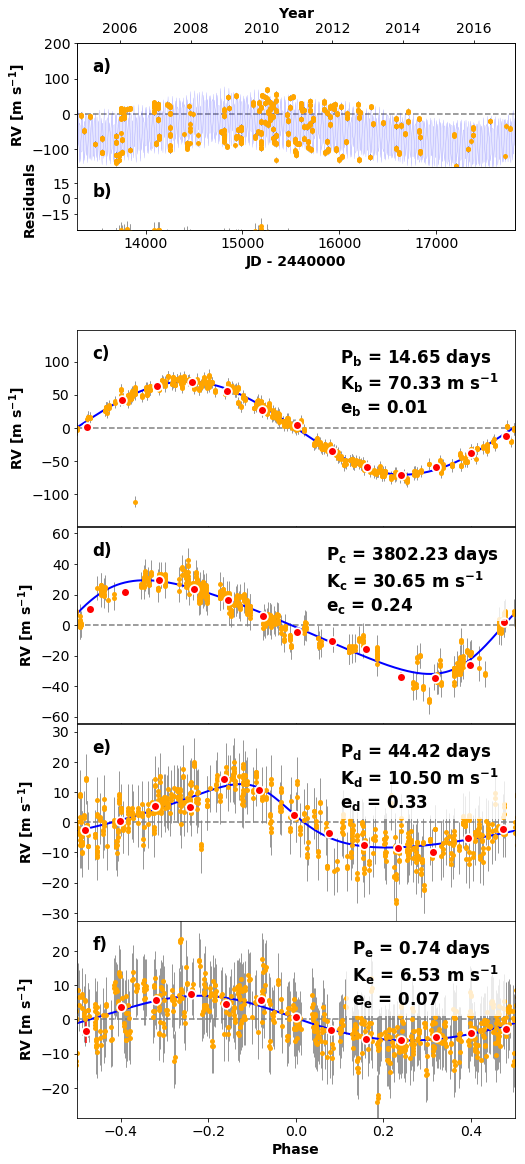

In [41]:
res  = optimize.minimize(
    post.neglogprob_array,     # objective function is negative log likelihood
    post.get_vary_params(),    # initial variable parameters
    method='Powell',           # Nelder-Mead also works
    )

plot_results(like)             # plot best fit model
print post
radvel.plotting.rv_multipanel_plot(post, epoch=2440000)

In [42]:
# res  = optimize.minimize(
#     post.neglogprob_array,     # objective function is negative log likelihood
#     post.get_vary_params(),    # initial variable parameters
#     method='Powell',           # Nelder-Mead also works
#     )
# #Get residuals
# #orbel = []
# #radvel.kepler.rv_drive(t)
# plot_results(like)             # plot best fit model
# print post
# radvel.plotting.rv_multipanel_plot(post, telfmts=radvel.plotting.telfmts_default,epoch=2440000)

In [43]:
Residuals_Radvel_4 = post.likelihood.residuals()
RMS_Radvel_4 = RMS(Residuals_Radvel_4)
print 'Radvel RMS of Residuals: ', RMS_Radvel_4
print ' '
print ' '

#model likelihood
four_planet= model_likelihood(post, True)

Radvel RMS of Residuals:  8.39195028685
 
 
N_free = 24
RMS = 8.39
logprob (jitter fixed) = -2213.72
chi (jitter fixed) = 681.63
chi_red (jitter fixed) = 1.13
BIC (jitter fixed) = 4457.88


# Initial Best Fit My Own Way (4th Planet)

Finding optimal frequency:
 - Estimated peak width = 0.00142
 - Using 5 steps per peak; omega_step = 0.000284
 - User-specified period range:  1 to 4.4e+03
 - Computing periods at 22126 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
period = 2.81733586558


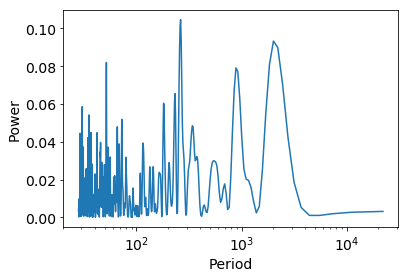

In [44]:
period4 = periodogram(t,residuals3,1,max(t)-min(t),nyquist)
#Corrected Alias Period
period4 = .7365417

Amplitude:  6.32872152229
Period:  0.736549256687
Phase Shift:  1.92715925441
Vertical-Shift:  2.392851062e-05
RMS of Residuals:  9.93614198547
RMS 9.93614198547
Chi Square 40964.7015552


C:\Users\rscsa\Anaconda2\lib\site-packages\ipykernel\__main__.py:25: RuntimeWarning: invalid value encountered in log


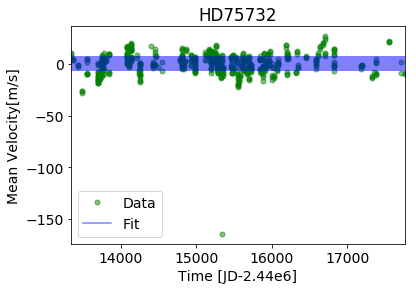

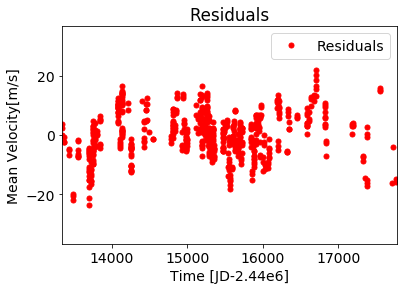

In [45]:
guess_amp = 15.
guess_pshft =0.
guess_vshft = 0.
residuals4, period4, likelihood4 = residuals(nplanets, t, residuals3, errvel, guess_amp, period4, guess_pshft, guess_vshft)

# 5th Planet Period

Finding optimal frequency:
 - Estimated peak width = 0.00142
 - Using 5 steps per peak; omega_step = 0.000284
 - User-specified period range:  1.2 to 4.4e+03
 - Computing periods at 18438 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
period = 264.546322176


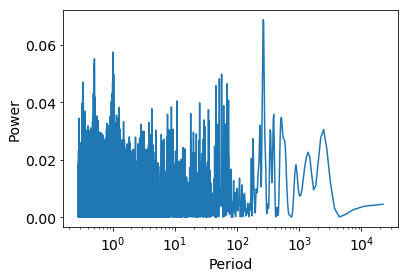

In [46]:
period_radvel_5 = periodogram(t,Residuals_Radvel_4,1.2,max(t)-min(t),50)

### NOTE: By adding correct Alius period periodogram naturally found the correct period
### Before the periodogram would find the alius again at 2.89days, meaning the power of the period
### was not reduced enough to allow another period to standout.
### To correct for that I would manually input the correct period seen below.

# period_radvel_5 = 259.7

In [47]:
nplanets = 5
# instnames = ['k', 'j']    # list of instrument names. Can be whatever you like but should match 'tel' column in the input file.
# ntels = len(instnames)       # number of instruments with unique velocity zero-points

def initialize_model():
    time_base = 2420
    params = radvel.RVParameters(nplanets,basis='per tc secosw sesinw logk')
    
    #1st Planet
    params['per1'] = post.params['per1']    # period of 1st planet
    params['tc1'] = post.params['tc1']   # time of inferior conjunction of 1st planet
    params['secosw1'] = post.params['secosw1']
    params['sesinw1'] =  post.params['sesinw1']
    params['logk1'] =  post.params['logk1']   # velocity semi-amplitude for 1st planet
    
    #2nd planet    
    params['per2'] = post.params['per2']
    params['tc2'] =  post.params['tc2']  
    params['secosw2'] = post.params['secosw2']
    params['sesinw2'] = post.params['sesinw2']
    params['logk2'] = post.params['logk2']  

    #3rd Planet
    params['per3'] = post.params['per3']
    params['tc3'] = post.params['tc3']
    params['secosw3'] = post.params['secosw3']
    params['sesinw3'] =  post.params['sesinw3']
    params['logk3'] = post.params['logk3']
    
    #4th Planet
    params['per4'] = post.params['per4']
    params['tc4'] = post.params['tc4']
    params['secosw4'] = post.params['secosw4']
    params['sesinw4'] = post.params['sesinw4']
    params['logk4'] = post.params['logk4']
    
    #5th Planet
    params['per5'] = period_radvel_5
    params['tc5'] = 2087.07  
    params['secosw5'] = 0.01
    params['sesinw5'] = 0.01
    params['logk5'] = np.log(RMS_Radvel_4)  
    

    mod = radvel.RVModel(params, time_base=time_base)
    mod.params['dvdt'] = 0.0         # slope
    mod.params['curv'] = 0.0        # curvature  
    return mod

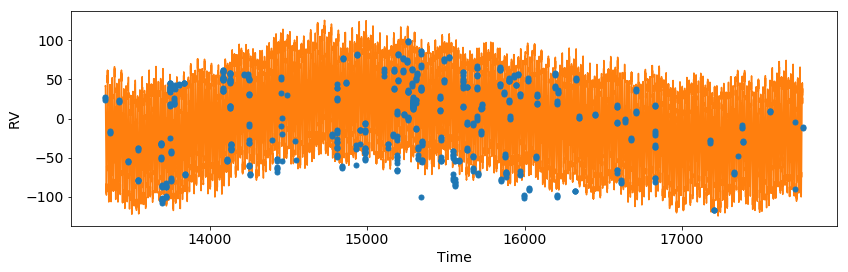

In [48]:
mod = initialize_model()
like = radvel.likelihood.RVLikelihood(mod, t, vel, errvel)
like.params['gamma'] = 1.0
like.params['jit'] = 2.6

like.vary['sesinw5'] = False
like.vary['secosw5'] = False
like.vary['curv'] = True
like.vary['dvdt'] = True

pl.figure()
plot_results(like)

In [49]:
post = radvel.posterior.Posterior(like)

post.priors += [radvel.prior.Gaussian('per1',like.params['per1'],.25*like.params['per1'])]
post.priors += [radvel.prior.Gaussian('per2',like.params['per2'],.25*like.params['per2'])]
post.priors += [radvel.prior.Gaussian('per3',like.params['per3'],.25*like.params['per3'])]
post.priors += [radvel.prior.Gaussian('per4',like.params['per4'],.25*like.params['per4'])]
# post.priors += [radvel.prior.Gaussian('per4',like.params['per4'],0.0000026)]
post.priors += [radvel.prior.Gaussian('per5',like.params['per5'],.25*like.params['per5'])]

post.priors += [radvel.prior.EccentricityPrior(nplanets)] #change for # of planets

post.priors += [radvel.prior.PositiveKPrior( nplanets )]

post.priors += [radvel.prior.Gaussian( 'jit', np.log(1), np.log(15))]

print post

parameter                     value      vary
per1                        14.6523       True
tc1                         2074.15       True
secosw1                  -0.0466767       True
sesinw1                    0.079454       True
logk1                       4.25318       True
per2                        3802.23       True
tc2                         915.546       True
secosw2                  -0.0878501       True
sesinw2                   -0.486143       True
logk2                       3.42275       True
per3                        44.4194       True
tc3                         2119.13       True
secosw3                     0.35566       True
sesinw3                    0.450029       True
logk3                       2.35148       True
per4                       0.736535       True
tc4                         1087.01       True
secosw4                    0.229959       True
sesinw4                    0.135491       True
logk4                       1.87597       True
per5          

parameter                     value      vary
per1                        14.6517       True
tc1                         2074.65       True
secosw1                  -0.0503367       True
sesinw1                    0.081496       True
logk1                       4.25303       True
per2                        3856.34       True
tc2                         602.163       True
secosw2                   0.0185939       True
sesinw2                   -0.464946       True
logk2                       3.43292       True
per3                        44.4146       True
tc3                         2121.08       True
secosw3                    0.325254       True
sesinw3                    0.391776       True
logk3                       2.36235       True
per4                       0.736542       True
tc4                         1086.87       True
secosw4                    0.237096       True
sesinw4                   0.0134869       True
logk4                       1.81967       True
per5          

(<matplotlib.figure.Figure at 0x16ff5518>,
  <matplotlib.axes._subplots.AxesSubplot at 0x19fb6f60>])

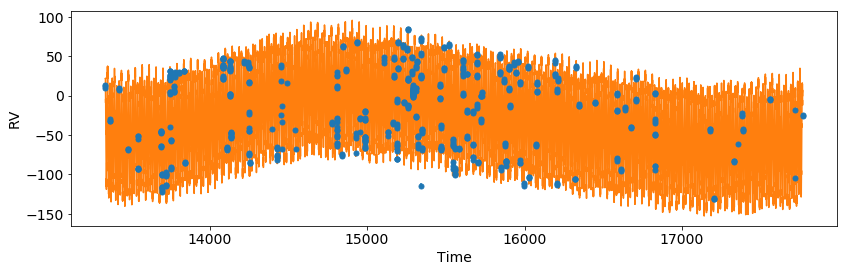

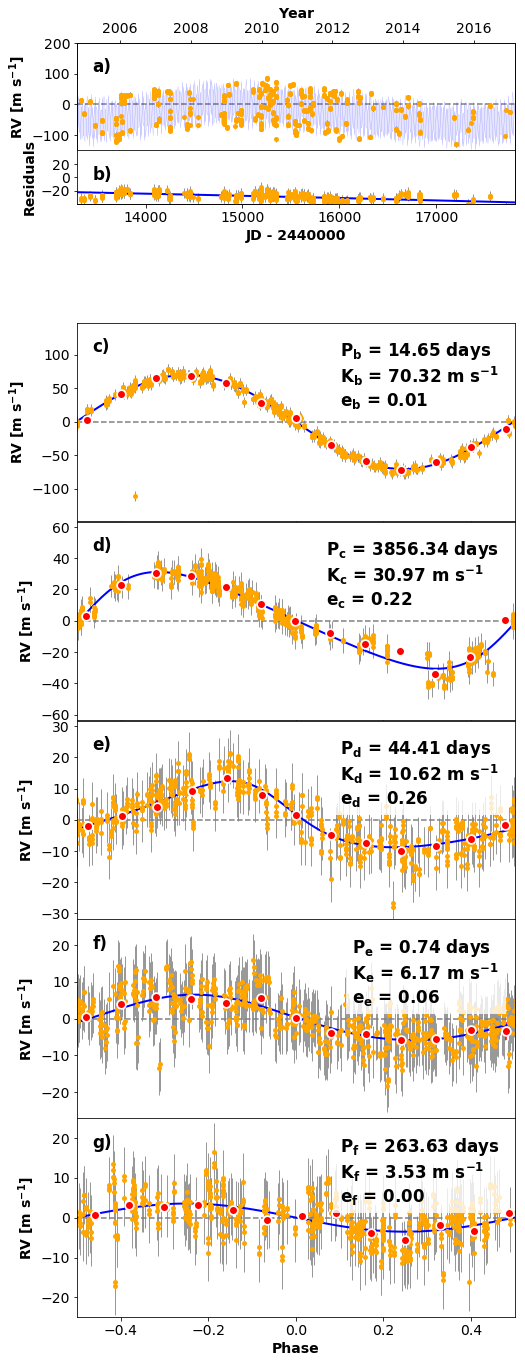

In [50]:
res  = optimize.minimize(
    post.neglogprob_array,     # objective function is negative log likelihood
    post.get_vary_params(),    # initial variable parameters
    method='Powell',           # Nelder-Mead also works
    )

plot_results(like)             # plot best fit model
print post
radvel.plotting.rv_multipanel_plot(post, epoch=2440000)

In [51]:
# res  = optimize.minimize(
#     post.neglogprob_array,     # objective function is negative log likelihood
#     post.get_vary_params(),    # initial variable parameters
#     method='Powell',           # Nelder-Mead also works
#     )
# #Get residuals
# #orbel = []
# #radvel.kepler.rv_drive(t)
# plot_results(like)             # plot best fit model
# print post
# radvel.plotting.rv_multipanel_plot(post, telfmts=radvel.plotting.telfmts_default,epoch=2440000)

In [52]:
Residuals_Radvel_5 = post.likelihood.residuals()
RMS_Radvel_5 = RMS(Residuals_Radvel_5)
print 'Radvel RMS of Residuals: ', RMS_Radvel_5
print ' '
print ' '

#model likelihood
five_planet= model_likelihood(post, True)

Radvel RMS of Residuals:  7.86049085765
 
 
N_free = 27
RMS = 7.86
logprob (jitter fixed) = -2165.11
chi (jitter fixed) = 695.03
chi_red (jitter fixed) = 1.15
BIC (jitter fixed) = 4363.66


# Initial Best Fit My Own Way (5th Planet)

Finding optimal frequency:
 - Estimated peak width = 0.00142
 - Using 5 steps per peak; omega_step = 0.000284
 - User-specified period range:  15 to 1.5e+03
 - Computing periods at 1462 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
period = 262.279815188


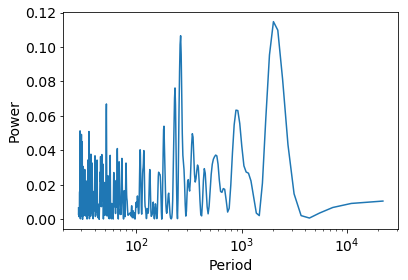

In [53]:
period5 = periodogram(t,residuals4,15,1500,nyquist)

Amplitude:  4.38355916867
Period:  262.966697541
Phase Shift:  1.9602405854
Vertical-Shift:  2.94140025572e-05
RMS of Residuals:  9.38857039061
RMS 9.38857039061
Chi Square 34061.0769057


C:\Users\rscsa\Anaconda2\lib\site-packages\ipykernel\__main__.py:25: RuntimeWarning: invalid value encountered in log


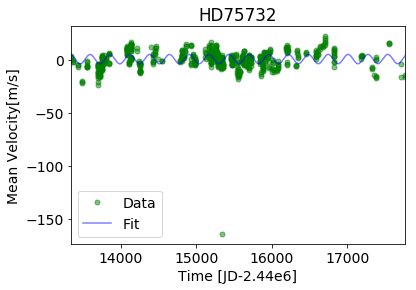

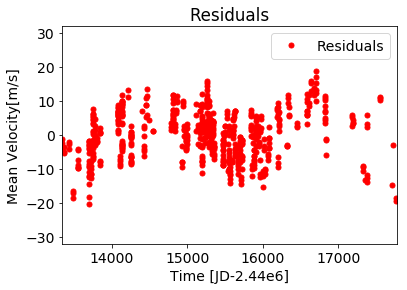

In [54]:
guess_amp = 10.
guess_pshft =0.
guess_vshft = 0.
residuals5, period5, likelihood5 = residuals(nplanets, t, residuals4, errvel, guess_amp, period5, guess_pshft, guess_vshft)

# Possible 6th Planet

Finding optimal frequency:
 - Estimated peak width = 0.00142
 - Using 5 steps per peak; omega_step = 0.000284
 - User-specified period range:  1.2 to 3e+03
 - Computing periods at 18435 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
period = 1425.26615393


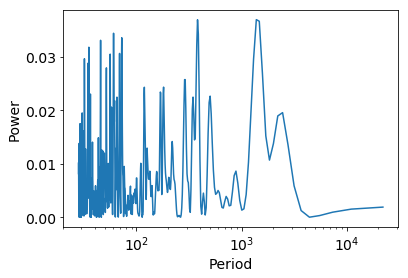

In [55]:
period_radvel_6 = periodogram(t,Residuals_Radvel_5,1.2,3*10**3,nyquist)

In [56]:
nplanets = 6
# instnames = ['k', 'j']    # list of instrument names. Can be whatever you like but should match 'tel' column in the input file.
# ntels = len(instnames)       # number of instruments with unique velocity zero-points

def initialize_model():
    time_base = 2420
    params = radvel.RVParameters(nplanets,basis='per tc secosw sesinw logk')
    
    #1st Planet
    params['per1'] = post.params['per1']    # period of 1st planet
    params['tc1'] = post.params['tc1']   # time of inferior conjunction of 1st planet
    params['secosw1'] = post.params['secosw1']
    params['sesinw1'] =  post.params['sesinw1']
    params['logk1'] =  post.params['logk1']   # velocity semi-amplitude for 1st planet
    
    #2nd planet    
    params['per2'] = post.params['per2']
    params['tc2'] =  post.params['tc2']  
    params['secosw2'] = post.params['secosw2']
    params['sesinw2'] = post.params['sesinw2']
    params['logk2'] = post.params['logk2']  

    #3rd Planet
    params['per3'] = post.params['per3']
    params['tc3'] = post.params['tc3']
    params['secosw3'] = post.params['secosw3']
    params['sesinw3'] =  post.params['sesinw3']
    params['logk3'] = post.params['logk3']
    
    #4th Planet
    params['per4'] = post.params['per4']
    params['tc4'] = post.params['tc4']
    params['secosw4'] = post.params['secosw4']
    params['sesinw4'] = post.params['sesinw4']
    params['logk4'] = post.params['logk4']
    
    #5th Planet
    params['per5'] = post.params['per5']
    params['tc5'] = post.params['tc5']
    params['secosw5'] = post.params['secosw5']
    params['sesinw5'] = post.params['sesinw5']
    params['logk5'] = post.params['logk5'] 
    
    #6th Planet
    params['per6'] = period_radvel_6
    params['tc6'] = 2087.07  
    params['secosw6'] = 0.01
    params['sesinw6'] = 0.01
    params['logk6'] = np.log(RMS_Radvel_5) 

    mod = radvel.RVModel(params, time_base=time_base)
    mod.params['dvdt'] = 0.0         # slope
    mod.params['curv'] = 0.0        # curvature  
    return mod

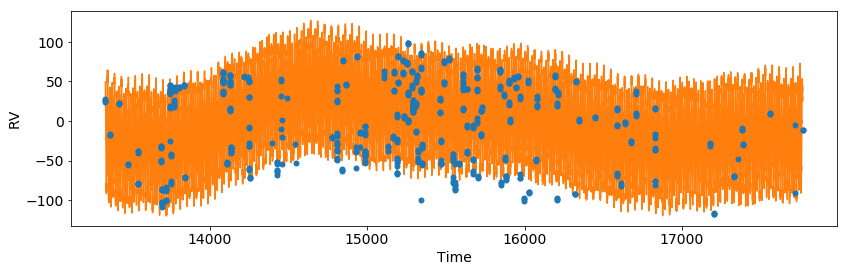

In [57]:
mod = initialize_model()
like = radvel.likelihood.RVLikelihood(mod, t, vel, errvel)
like.params['gamma'] = 1.0
like.params['jit'] = 2.6

like.vary['sesinw5'] = False
like.vary['secosw5'] = False
like.vary['sesinw6'] = False
like.vary['secosw6'] = False

like.vary['curv'] = True
like.vary['dvdt'] = True

pl.figure()
plot_results(like)

In [58]:
post = radvel.posterior.Posterior(like)

post.priors += [radvel.prior.Gaussian('per1',like.params['per1'],.25*like.params['per1'])]
post.priors += [radvel.prior.Gaussian('per2',like.params['per2'],.25*like.params['per2'])]
post.priors += [radvel.prior.Gaussian('per3',like.params['per3'],.25*like.params['per3'])]
post.priors += [radvel.prior.Gaussian('per4',like.params['per4'],.25*like.params['per4'])]
post.priors += [radvel.prior.Gaussian('per5',like.params['per5'],.25*like.params['per5'])]
post.priors += [radvel.prior.Gaussian('per6',like.params['per6'],.25*like.params['per6'])]


post.priors += [radvel.prior.EccentricityPrior(nplanets)] #change for # of planets

post.priors += [radvel.prior.PositiveKPrior( nplanets )]

post.priors += [radvel.prior.Gaussian( 'jit', np.log(1), np.log(15))]

print post

parameter                     value      vary
per1                        14.6517       True
tc1                         2074.65       True
secosw1                  -0.0503367       True
sesinw1                    0.081496       True
logk1                       4.25303       True
per2                        3856.34       True
tc2                         602.163       True
secosw2                   0.0185939       True
sesinw2                   -0.464946       True
logk2                       3.43292       True
per3                        44.4146       True
tc3                         2121.08       True
secosw3                    0.325254       True
sesinw3                    0.391776       True
logk3                       2.36235       True
per4                       0.736542       True
tc4                         1086.87       True
secosw4                    0.237096       True
sesinw4                   0.0134869       True
logk4                       1.81967       True
per5          

parameter                     value      vary
per1                        14.6517       True
tc1                         2074.69       True
secosw1                  0.00302267       True
sesinw1                   0.0595405       True
logk1                       4.24682       True
per2                        3904.25       True
tc2                         702.236       True
secosw2                   -0.352824       True
sesinw2                   -0.394824       True
logk2                       3.45821       True
per3                        44.4229       True
tc3                         2118.99       True
secosw3                    0.299763       True
sesinw3                     0.36949       True
logk3                       2.36261       True
per4                       0.736544       True
tc4                         1086.82       True
secosw4                    0.288387       True
sesinw4                  -0.0315215       True
logk4                       1.82239       True
per5          

(<matplotlib.figure.Figure at 0x19e5f7b8>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1a88b828>])

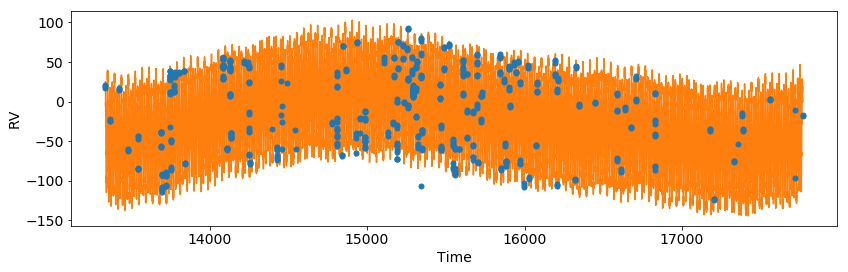

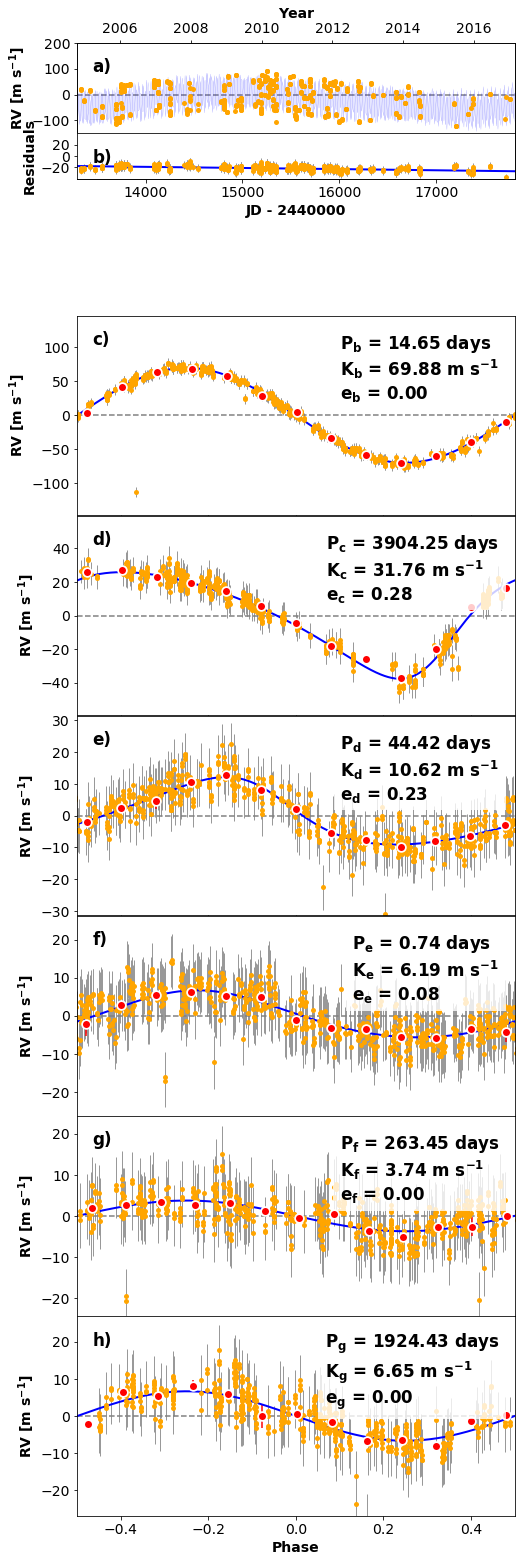

In [59]:
res  = optimize.minimize(
    post.neglogprob_array,     # objective function is negative log likelihood
    post.get_vary_params(),    # initial variable parameters
    method='Powell',           # Nelder-Mead also works
    )

plot_results(like)             # plot best fit model
print post
radvel.plotting.rv_multipanel_plot(post, epoch=2440000)

In [60]:
Residuals_Radvel_6 = post.likelihood.residuals()
RMS_Radvel_6 = RMS(Residuals_Radvel_6)
print 'Radvel RMS of Residuals: ', RMS_Radvel_6
print ' '
print ' '

#model likelihood
six_planet= model_likelihood(post, True)

Radvel RMS of Residuals:  7.60770285026
 
 
N_free = 30
RMS = 7.61
logprob (jitter fixed) = -2139.66
chi (jitter fixed) = 708.09
chi_red (jitter fixed) = 1.18
BIC (jitter fixed) = 4315.75


# Initial Best Fit My Own Way (6th Planet)

Finding optimal frequency:
 - Estimated peak width = 0.00142
 - Using 5 steps per peak; omega_step = 0.000284
 - User-specified period range:  15 to 2e+03
 - Computing periods at 1466 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
period = 2082.82625839


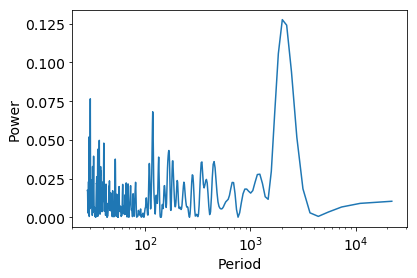

In [61]:
period6 = periodogram(t,residuals5,15,2000,nyquist)

Amplitude:  5.29297489874
Period:  2085.78473985
Phase Shift:  -0.125721262423
Vertical-Shift:  8.9204957541e-05
RMS of Residuals:  8.75627190793
RMS 8.75627190793
Chi Square 27010.253283


C:\Users\rscsa\Anaconda2\lib\site-packages\ipykernel\__main__.py:25: RuntimeWarning: invalid value encountered in log


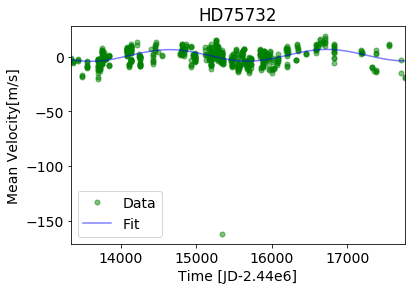

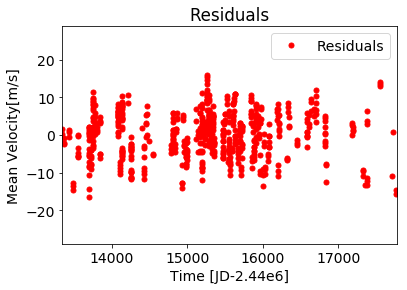

In [62]:
guess_amp = 10.
guess_pshft =0.
guess_vshft = 0.
residuals6, period6, likelihood6 = residuals(nplanets, t, residuals5, errvel, guess_amp, period6, guess_pshft, guess_vshft)

# Results

Periods of all Planets

In [63]:
header_likely = ['Method','1st Planet','2nd Planet', '3rd Planet', '4th Planet', '5th Planet', '6th Planet']
radvel_periods = ['Radvel',period1,period_radvel_2,period_radvel_3,period_radvel_4,period_radvel_5,period_radvel_6]
own_periods = ['Own',period1,period2,period3, period4,period5,period6]
print 'PERIODS FOR PLANETS'
print ''
print tabulate([radvel_periods, own_periods],headers=header_likely)

PERIODS FOR PLANETS

Method      1st Planet    2nd Planet    3rd Planet    4th Planet    5th Planet    6th Planet
--------  ------------  ------------  ------------  ------------  ------------  ------------
Radvel          14.653       3782.79       44.4069      0.736542       264.546       1425.27
Own             14.653       4264.07       44.3961      0.736549       262.967       2085.78


Model Comparison using Radvel

In [64]:
header_likely = ['num_planets','# Data', 'Free Params', 'RMS', 'Logprob', 'chi', 'chi_red', 'BIC']
print 'MODEL COMPARISON RADVEL'
print ''
print tabulate([one_planet,two_planet,three_planet,four_planet,five_planet,six_planet],headers=header_likely)

MODEL COMPARISON RADVEL

  num_planets    # Data    Free Params       RMS    Logprob      chi    chi_red      BIC
-------------  --------  -------------  --------  ---------  -------  ---------  -------
            1       629              9  22.361     -2879.07  689.428    1.11198  5773.59
            2       629             14  14.8438    -2602.28  662.301    1.07691  5225.01
            3       629             19  10.0078    -2337.97  655.32     1.07429  4701.38
            4       629             24   8.39195   -2213.72  681.635    1.12667  4457.88
            5       629             27   7.86049   -2165.11  695.033    1.15454  4363.66
            6       629             30   7.6077    -2139.66  708.095    1.18213  4315.75


Model Comparison using my own method

In [65]:
print 'MODEL COMPARISON FOR OWN METHOD'
print ''
print tabulate([likelihood1,likelihood2,likelihood3,likelihood4,likelihood5,likelihood6],headers=header_likely)

MODEL COMPARISON FOR OWN METHOD

  num_planets    # Data    Free Params       RMS    Logprob       chi    chi_red        BIC
-------------  --------  -------------  --------  ---------  --------  ---------  ---------
            1       629              4  22.3551     4.55547  324902     519.843     1.33319
            2       629              4  12.6265   nan         82813.4   132.501   nan
            3       629              4  10.882    nan         54449.2    87.1187  nan
            4       629              4   9.93614  nan         40964.7    65.5435  nan
            5       629              4   9.38857  nan         34061.1    54.4977  nan
            6       629              4   8.75627  nan         27010.3    43.2164  nan


# Ignore Everything Below This

Define a function that we will use to initialize the ``radvel.RVParameters`` and ``radvel.RVModel`` objects

curv                   -7.39154e-08       True
dvdt                   -0.000573222       True
gamma                       4.61095       True
jit                         11.2417       True
logk1                       4.24819       True
logk2                       3.42597       True
per1                        14.6521       True
per2                        3901.48       True
secosw1                   0.0647091       True
secosw2                   0.0836947       True
sesinw1                     0.10735       True
sesinw2                   -0.419884       True
tc1                         2074.21       True
tc2                         4268.95       True

# MCMC Chain

Now lets use Markov-Chain Monte Carlo (MCMC) to estimate the parameter uncertainties.

In [66]:
# df = radvel.mcmc(post,nwalkers=50,nrun=5000)

Now lets make a corner plot to display the posterior distributions.

In [67]:
# radvel.plotting.corner_plot(post, df)

In [68]:
# print post
# radvel.plotting.rv_multipanel_plot(post, epoch=2440000)

In [69]:
"""
df['k1'] = np.exp(df['logk1'])
df['k2'] = np.exp(df['logk2'])
df['k3'] = np.exp(df['logk3'])
df['k4'] = np.exp(df['logk4'])
df['jit'] = np.exp(df['jit'])
df['e1'] = df['secosw1']**2 + df['sesinw1']**2
df['e2'] = df['secosw2']**2 + df['sesinw2']**2
df['e3'] = df['secosw3']**2 + df['sesinw3']**2
df['e4'] = df['secosw4']**2 + df['sesinw4']**2

df['ecosw1'] = df['secosw1']*np.sqrt(df['e1'])
df['esinw1'] = df['sesinw1']*np.sqrt(df['e1'])

df['ecosw2'] = df['secosw2']*np.sqrt(df['e2'])
df['esinw2'] = df['sesinw2']*np.sqrt(df['e2'])

df['ecosw3'] = df['secosw3']*np.sqrt(df['e3'])
df['esinw3'] = df['sesinw3']*np.sqrt(df['e3'])

df['ecosw4'] = df['secosw4']*np.sqrt(df['e4'])
df['esinw4'] = df['sesinw4']*np.sqrt(df['e4'])

labels = 'k1 k2 k3 k4 jit e1 e2 e3 e4'.split()
fig = corner.corner(
    df[labels],
    labels=labels,
    levels=[0.68,0.95],
    plot_datapoints=False,
    smooth=True,
    bins=20,
    quantiles=[.14,.5,.84,]
    )
"""

"\ndf['k1'] = np.exp(df['logk1'])\ndf['k2'] = np.exp(df['logk2'])\ndf['k3'] = np.exp(df['logk3'])\ndf['k4'] = np.exp(df['logk4'])\ndf['jit'] = np.exp(df['jit'])\ndf['e1'] = df['secosw1']**2 + df['sesinw1']**2\ndf['e2'] = df['secosw2']**2 + df['sesinw2']**2\ndf['e3'] = df['secosw3']**2 + df['sesinw3']**2\ndf['e4'] = df['secosw4']**2 + df['sesinw4']**2\n\ndf['ecosw1'] = df['secosw1']*np.sqrt(df['e1'])\ndf['esinw1'] = df['sesinw1']*np.sqrt(df['e1'])\n\ndf['ecosw2'] = df['secosw2']*np.sqrt(df['e2'])\ndf['esinw2'] = df['sesinw2']*np.sqrt(df['e2'])\n\ndf['ecosw3'] = df['secosw3']*np.sqrt(df['e3'])\ndf['esinw3'] = df['sesinw3']*np.sqrt(df['e3'])\n\ndf['ecosw4'] = df['secosw4']*np.sqrt(df['e4'])\ndf['esinw4'] = df['sesinw4']*np.sqrt(df['e4'])\n\nlabels = 'k1 k2 k3 k4 jit e1 e2 e3 e4'.split()\nfig = corner.corner(\n    df[labels],\n    labels=labels,\n    levels=[0.68,0.95],\n    plot_datapoints=False,\n    smooth=True,\n    bins=20,\n    quantiles=[.14,.5,.84,]\n    )\n"

In [70]:
# print post
# radvel.plotting.rv_multipanel_plot(post, epoch=2440000)

In [71]:
a = radvel.posterior.bic()

AttributeError: 'module' object has no attribute 'bic'